Creado por Daniel Pacheco y Manuel Neira

In [ ]:
#libreria necesaria para el manejo de numeros, arrays, etc.
import numpy as np
#libreria necesaria para el manejo de datasets y algunas funcionalidades de estos
import pandas as pd
#libreria necesaria para poder agrupar por categorias especificas un rango de datos
from sklearn.preprocessing import LabelEncoder
#librerias necesarias para graficar y realizar algunas modificaciones en los graficos
import matplotlib.pyplot as plt
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D
#lirebria necesaria para usar el modulo de clusterizacion k-vecinos
from sklearn.cluster import KMeans
#libreria necesaria para computar la distancia entre un grupo de puntos y uno en especifico
from sklearn.metrics import pairwise_distances_argmin_min
#libreria necesaria para la normalizacion de un rango de datos
from sklearn.preprocessing import normalize
#libreria necesaria para trabajar con modulos de clusterizacion de tipo jerarquicos
import scipy.cluster.hierarchy as shc
#libreria necesaria para trabajar con modulos de clusterizacion de Mezcla Gausiana
from sklearn.mixture import GaussianMixture
#libreria necesaria para trabajar con modulos de clusterizacion de tipo aglomerativos
from sklearn.cluster import AgglomerativeClustering

# Preprocesamiento de los datos

In [ ]:
#Se carga el dataset
datos = pd.read_csv("EVA.csv")
#Visualizar número de filas y columnas del dataset
datos.shape

(206068, 17)

In [ ]:
datos

,CÓD. \nDEP.,DEPARTAMENTO,CÓD. MUN.,MUNICIPIO,GRUPO \nDE CULTIVO,SUBGRUPO \nDE CULTIVO,CULTIVO,DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO,AÑO,PERIODO,Área Sembrada\n(ha),Área Cosechada\n(ha),Producción\n(t),Rendimiento\n(t/ha),ESTADO FISICO PRODUCCION,NOMBRE \nCIENTIFICO,CICLO DE CULTIVO
0,15,BOYACA,15114,BUSBANZA,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,2,1,1,1.00,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
1,25,CUNDINAMARCA,25754,SOACHA,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,82,80,1440,18.00,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
2,25,CUNDINAMARCA,25214,COTA,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,2,2,26,17.33,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
3,54,NORTE DE SANTANDER,54405,LOS PATIOS,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,3,3,48,16.00,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
4,54,NORTE DE SANTANDER,54518,PAMPLONA,HORTALIZAS,ACELGA,ACELGA,ACELGA,2006,2006B,1,1,5,10.00,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206063,25,CUNDINAMARCA,25436,MANTA,HORTALIZAS,CALABACIN,CALABACIN,ZUCCHINI,2017,2017B,20,18,180,10.00,HORTALIZA FRESCA,CUCURBITA PEPO,TRANSITORIO
206064,25,CUNDINAMARCA,25524,PANDI,HORTALIZAS,CALABACIN,CALABACIN,ZUCCHINI,2017,2017B,2,2,8,5.00,HORTALIZA FRESCA,CUCURBITA PEPO,TRANSITORIO
206065,25,CUNDINAMARCA,25436,MANTA,HORTALIZAS,CALABACIN,CALABACIN,ZUCCHINI,2018,2018A,15,15,150,10.00,HORTALIZA FRESCA,CUCURBITA PEPO,TRANSITORIO
206066,25,CUNDINAMARCA,25807,TIBIRITA,HORTALIZAS,CALABACIN,CALABACIN,ZUCCHINI,2018,2018A,6,6,50,8.27,HORTALIZA FRESCA,CUCURBITA PEPO,TRANSITORIO


In [ ]:
#Filtramos y borramos filas que no figuren con  año dentro del rango: 2014-2018 (Esto debido a que se produce desbordamiento de memoria al crear cluster)
datos.drop(datos[datos['AÑO'] < 2017].index, inplace = True)
#Visualizamos de nuevo número de filas y columnas del dataset
datos.shape

(32852, 17)

In [ ]:
#Quitamos NAN Values
datos = datos.fillna(0)
datos.dropna(axis=1)
#datos = datos.drop(datos.columns[[1]], axis=1) #Eliminamo la columna 'RESIDENCIAL' debido a que todo el dataframe trata de tarifas de servicio resi
#Renombramos colunmas
datos.rename(columns={'Área Sembrada\n(ha)':'Area Sembrada', 'Área Cosechada\n(ha)':'Area Cosechada', 'Producción\n(t)':'Produccion', 'Rendimiento\n(t/ha)':'Rendimiento', 'GRUPO \nDE CULTIVO':'GRUPO DE CULTIVO', 'SUBGRUPO \nDE CULTIVO':'SUBGRUPO DE CULTIVO', 'NOMBRE \nCIENTIFICO':'NOMBRE CIENTIFICO','CÓD. \nDEP.':'CÓD. DEPT.'},inplace=True)
#Convertimos valores  flot64 de la columna Rendimiento a int64
datos['Rendimiento'] = datos['Rendimiento'].astype(np.int64)
# Convertimos datos de la columna 
#datos['Rendimiento\n(t/ha)'] = datos['Rendimiento\n(t/ha)'].astype(np.int64)
#Efectuamos conteo de acuerdo al ciclo de cultivo
datos['CICLO DE CULTIVO'].value_counts().count()
#Aplicamos a los datos  la función estádistica descriptiva 
datos.describe()

,CÓD. DEPT.,CÓD. MUN.,AÑO,Area Sembrada,Area Cosechada,Produccion,Rendimiento
count,32852.000000,32852.000000,32852.000000,32852.000000,32852.000000,3.285200e+04,32852.000000
mean,39.472726,39901.491964,2017.429076,312.826221,270.754292,3.356485e+03,9.612261
std,25.150494,25130.195021,0.494952,1391.419376,1185.860851,5.272323e+04,15.745593
min,5.000000,5001.000000,2017.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,17.000000,17442.000000,2017.000000,9.000000,7.000000,3.300000e+01,1.000000
50%,41.000000,41078.000000,2017.000000,32.000000,28.000000,1.500000e+02,5.000000
75%,66.000000,66088.000000,2018.000000,150.000000,125.000000,7.000000e+02,12.000000
max,99.000000,99773.000000,2018.000000,46535.000000,35000.000000,4.300436e+06,240.000000


In [ ]:
#Reseteamos index del DataFrame
datos.reset_index(drop=True)

,CÓD. DEPT.,DEPARTAMENTO,CÓD. MUN.,MUNICIPIO,GRUPO DE CULTIVO,SUBGRUPO DE CULTIVO,CULTIVO,DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO,AÑO,PERIODO,Area Sembrada,Area Cosechada,Produccion,Rendimiento,ESTADO FISICO PRODUCCION,NOMBRE CIENTIFICO,CICLO DE CULTIVO
0,5,ANTIOQUIA,5440,MARINILLA,HORTALIZAS,ACELGA,ACELGA,ACELGA,2017,2017A,9,9,243,27,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
1,15,BOYACA,15879,VIRACACHA,HORTALIZAS,ACELGA,ACELGA,ACELGA,2017,2017A,2,2,8,4,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
2,15,BOYACA,15759,SOGAMOSO,HORTALIZAS,ACELGA,ACELGA,ACELGA,2017,2017A,1,1,6,6,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
3,18,CAQUETA,18205,CURILLO,HORTALIZAS,ACELGA,ACELGA,ACELGA,2017,2017A,2,1,3,3,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
4,19,CAUCA,19807,TIMBIO,HORTALIZAS,ACELGA,ACELGA,ACELGA,2017,2017A,12,9,36,4,FRUTO FRESCO,BETA VULGARIS,TRANSITORIO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32847,25,CUNDINAMARCA,25436,MANTA,HORTALIZAS,CALABACIN,CALABACIN,ZUCCHINI,2017,2017B,20,18,180,10,HORTALIZA FRESCA,CUCURBITA PEPO,TRANSITORIO
32848,25,CUNDINAMARCA,25524,PANDI,HORTALIZAS,CALABACIN,CALABACIN,ZUCCHINI,2017,2017B,2,2,8,5,HORTALIZA FRESCA,CUCURBITA PEPO,TRANSITORIO
32849,25,CUNDINAMARCA,25436,MANTA,HORTALIZAS,CALABACIN,CALABACIN,ZUCCHINI,2018,2018A,15,15,150,10,HORTALIZA FRESCA,CUCURBITA PEPO,TRANSITORIO
32850,25,CUNDINAMARCA,25807,TIBIRITA,HORTALIZAS,CALABACIN,CALABACIN,ZUCCHINI,2018,2018A,6,6,50,8,HORTALIZA FRESCA,CUCURBITA PEPO,TRANSITORIO


In [ ]:
#Codificacion
datos['CICLO DE CULTIVO']=datos['CICLO DE CULTIVO'].astype('category')
datos['CICLO DE CULTIVO2'] = datos['CICLO DE CULTIVO'].cat.codes

# **Clustering Jerarquico**

In [ ]:
#borramos algunas columnas para evitar conflictos con la normalización
datos.head()
datos_dropped = datos.copy()
datos_dropped = datos.drop(datos.columns[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9,14,15,16,17]], axis=1)
datos_dropped

,Area Sembrada,Area Cosechada,Produccion,Rendimiento
171,9,9,243,27
172,2,2,8,4
173,1,1,6,6
174,2,1,3,3
175,12,9,36,4
...,...,...,...,...
206063,20,18,180,10
206064,2,2,8,5
206065,15,15,150,10
206066,6,6,50,8


In [ ]:
datos.dtypes

CÓD. DEPT.                                          int64
DEPARTAMENTO                                       object
CÓD. MUN.                                           int64
MUNICIPIO                                          object
GRUPO DE CULTIVO                                   object
SUBGRUPO DE CULTIVO                                object
CULTIVO                                            object
DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO      object
AÑO                                                 int64
PERIODO                                            object
Area Sembrada                                       int64
Area Cosechada                                      int64
Produccion                                          int64
Rendimiento                                         int64
ESTADO FISICO PRODUCCION                           object
NOMBRE CIENTIFICO                                  object
CICLO DE CULTIVO                                 category
CICLO DE CULTI

In [ ]:
#normalizamos los datos
datos_scaled = normalize(datos_dropped)
datos_scaled = pd.DataFrame(datos_scaled, columns=datos_dropped.columns)
datos_scaled.head()

,Area Sembrada,Area Cosechada,Produccion,Rendimiento
0,0.036761,0.036761,0.992540,0.110282
1,0.213201,0.213201,0.852803,0.426401
2,0.116248,0.116248,0.697486,0.697486
3,0.417029,0.208514,0.625543,0.625543
4,0.306087,0.229565,0.918260,0.102029


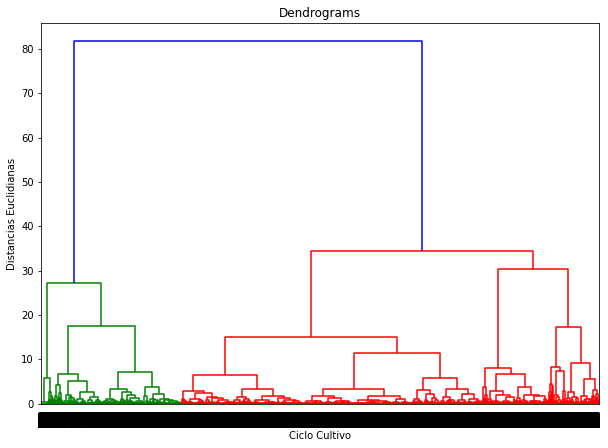

In [ ]:
#Necesitamos conocer la distancia entre cada uno de los puntos, para ello hacemos un dendrograma
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
plt.xlabel('Ciclo Cultivo')
plt.ylabel('Distancias Euclidianas')
dend = shc.dendrogram(shc.linkage(datos_scaled, method='ward',metric='euclidean'))

Para definir el número de clúster óptimo se realizo la demarcación de una línea en el dendrograma para observar la distancia máxima, definiendo así que el número de clúster óptimos es 2

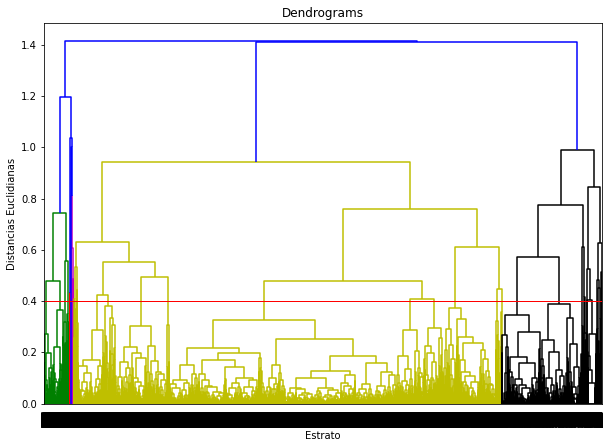

In [ ]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
plt.xlabel('Estrato')
plt.ylabel('Distancias Euclidianas')
dend = shc.dendrogram(shc.linkage(datos_scaled, method='complete',metric='euclidean'))
# Agregamos una línea horizontal a la altura de 0.4
plt.axhline(y=0.4, c='red', lw=1, linestyle='solid')

Para definir el número de clúster óptimo se realizo la demarcación de una línea en el dendrograma para observar la distancia máxima, definiendo así que el número de clúster óptimos es 3

In [ ]:
plt.scatter(datos_scaled[y_hc == 0, 0], datos_scaled[y_hc == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(datos_scaled[y_hc == 1, 0], datos_scaled[y_hc == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(datos_scaled[y_hc == 2, 0], datos_scaled[y_hc == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.title('Clusters of Crime')
plt.xlabel('Years')
plt.ylabel('Crime rate')
plt.legend()
plt.show()

NameError: ignored

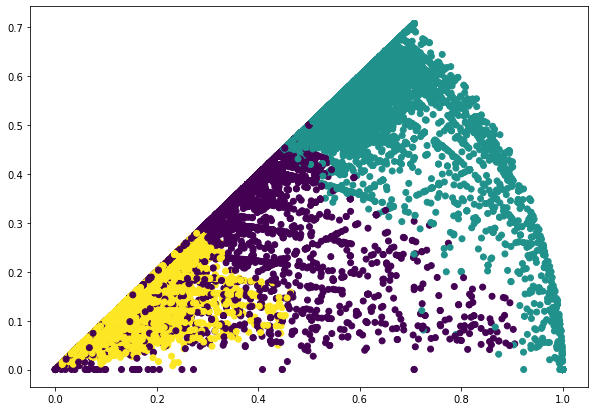

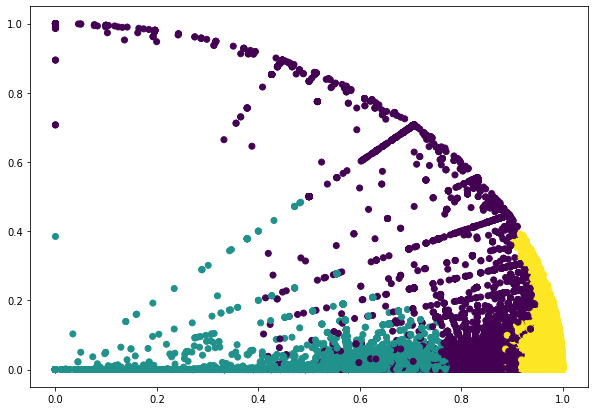

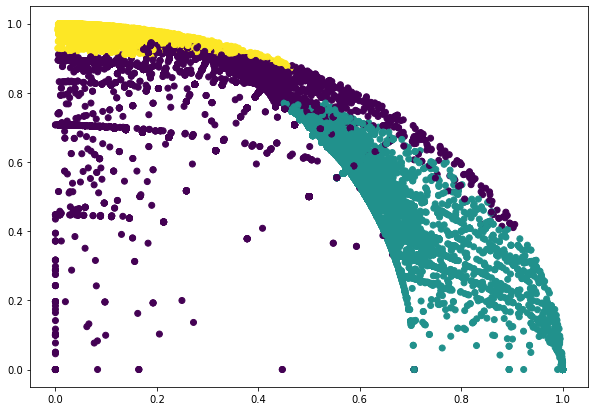

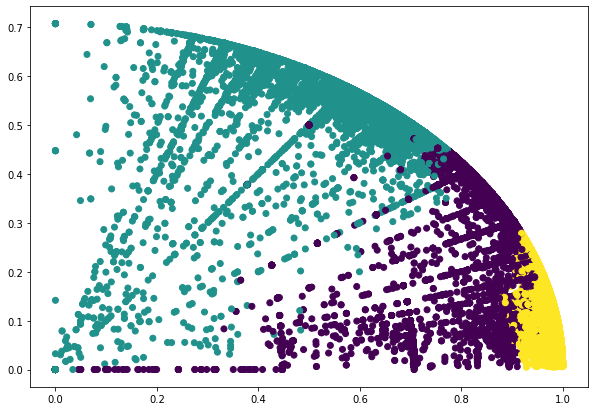

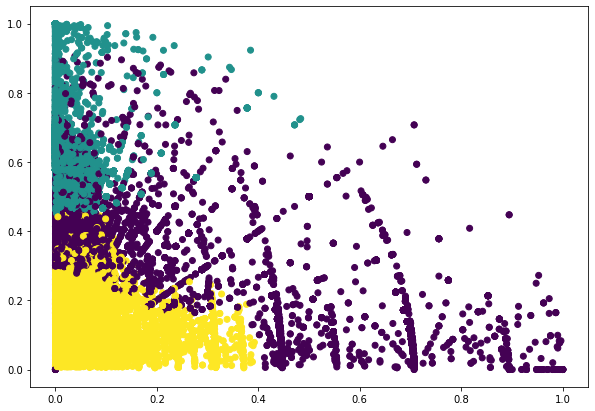

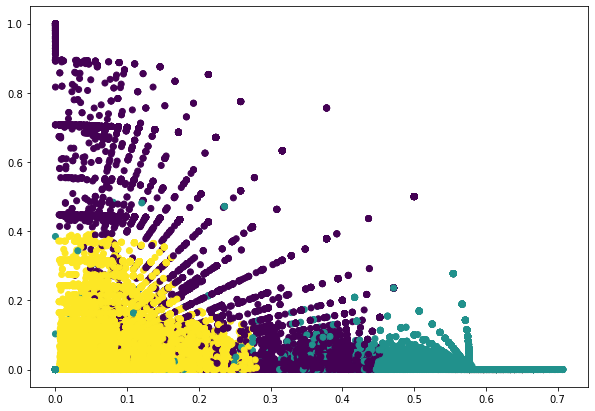

In [ ]:
#Se prosige a generar los clusters
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(datos_scaled)

plt.figure(figsize=(10, 7))  
plt.scatter(datos_scaled['Area Sembrada'], datos_scaled['Area Cosechada'], c=cluster.labels_) 

plt.figure(figsize=(10, 7))  
plt.scatter(datos_scaled['Produccion'], datos_scaled['Rendimiento'], c=cluster.labels_) 

plt.figure(figsize=(10, 7))  
plt.scatter(datos_scaled['Area Sembrada'], datos_scaled['Produccion'], c=cluster.labels_)

plt.figure(figsize=(10, 7))  
plt.scatter(datos_scaled['Produccion'], datos_scaled['Area Cosechada'], c=cluster.labels_)

plt.figure(figsize=(10, 7))  
plt.scatter(datos_scaled['Rendimiento'], datos_scaled['Area Sembrada'], c=cluster.labels_)

plt.figure(figsize=(10, 7))  
plt.scatter(datos_scaled['Area Cosechada'], datos_scaled['Rendimiento'], c=cluster.labels_)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


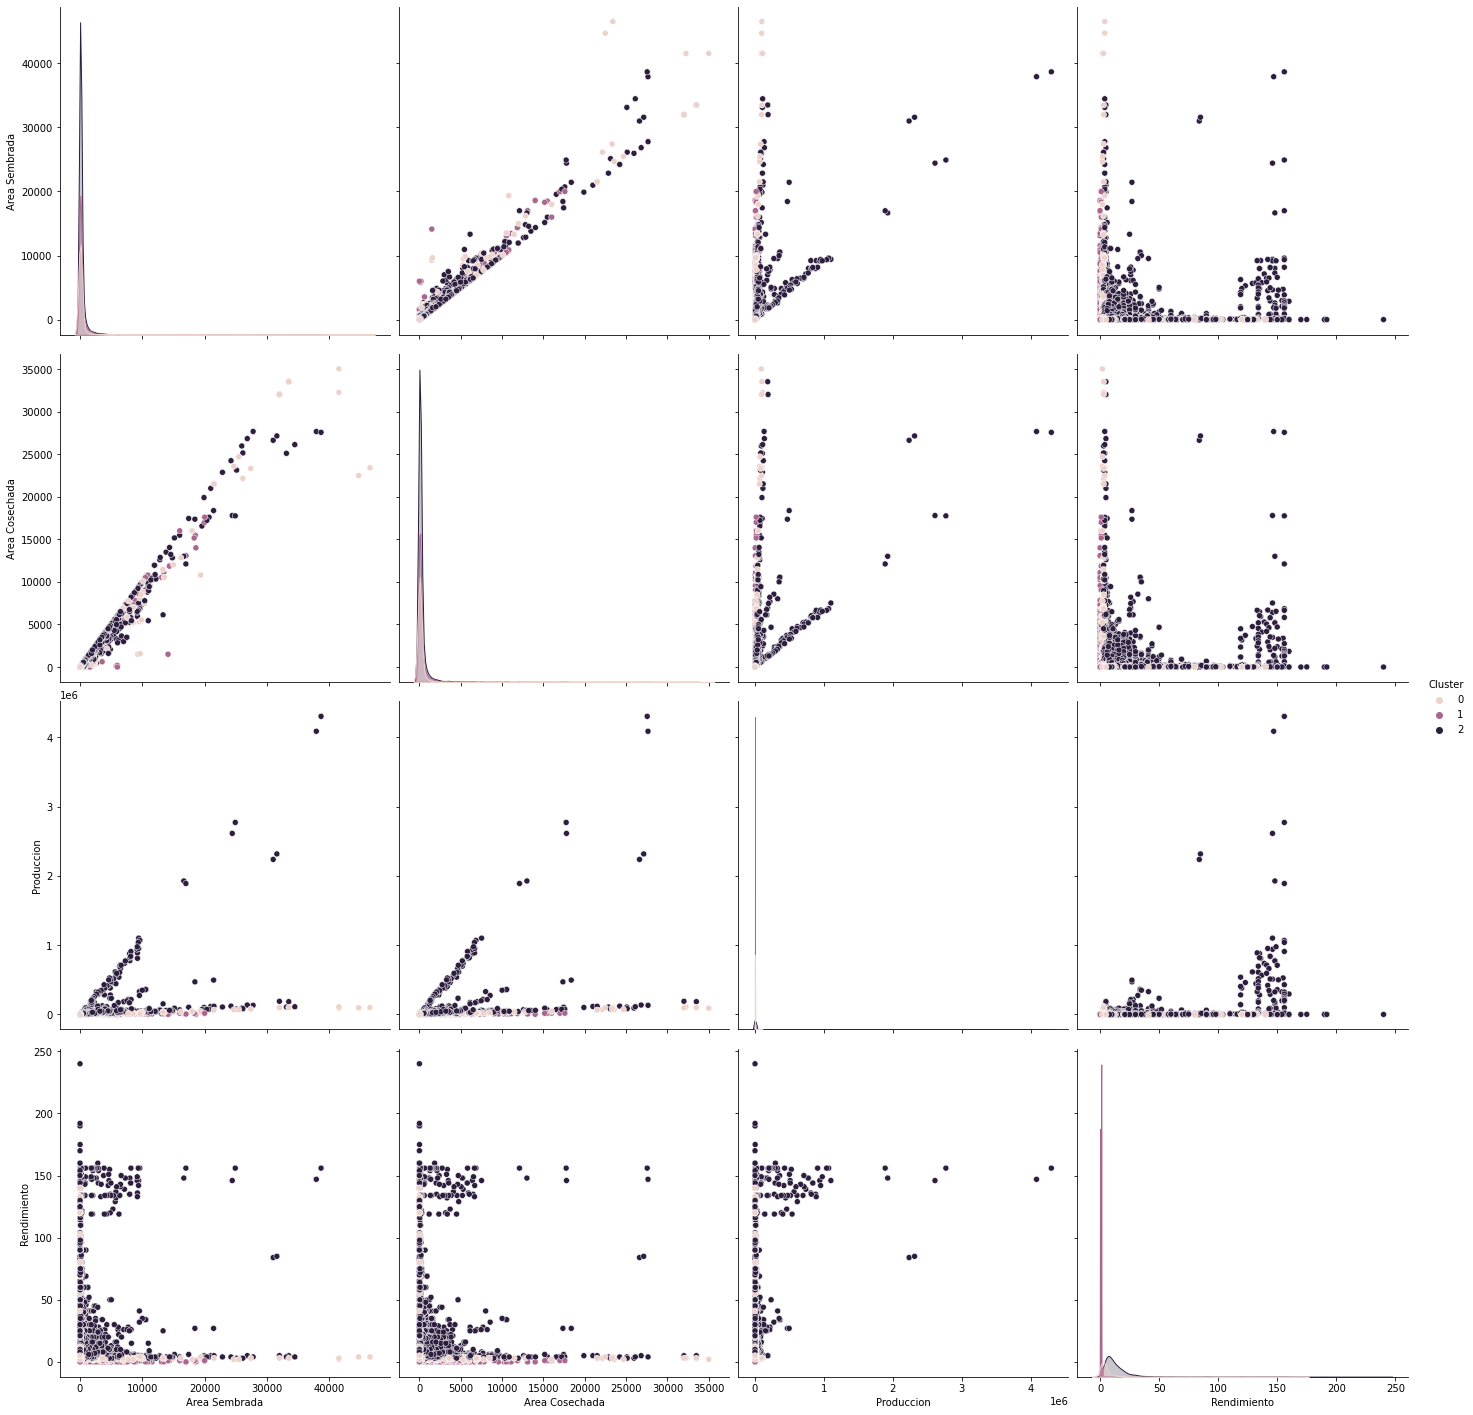

In [ ]:
datos['Cluster']=cluster.labels_
sb.pairplot(datos.dropna(), hue='Cluster',size=5,vars=['Area Sembrada','Area Cosechada','Produccion', 'Rendimiento'],kind='scatter')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


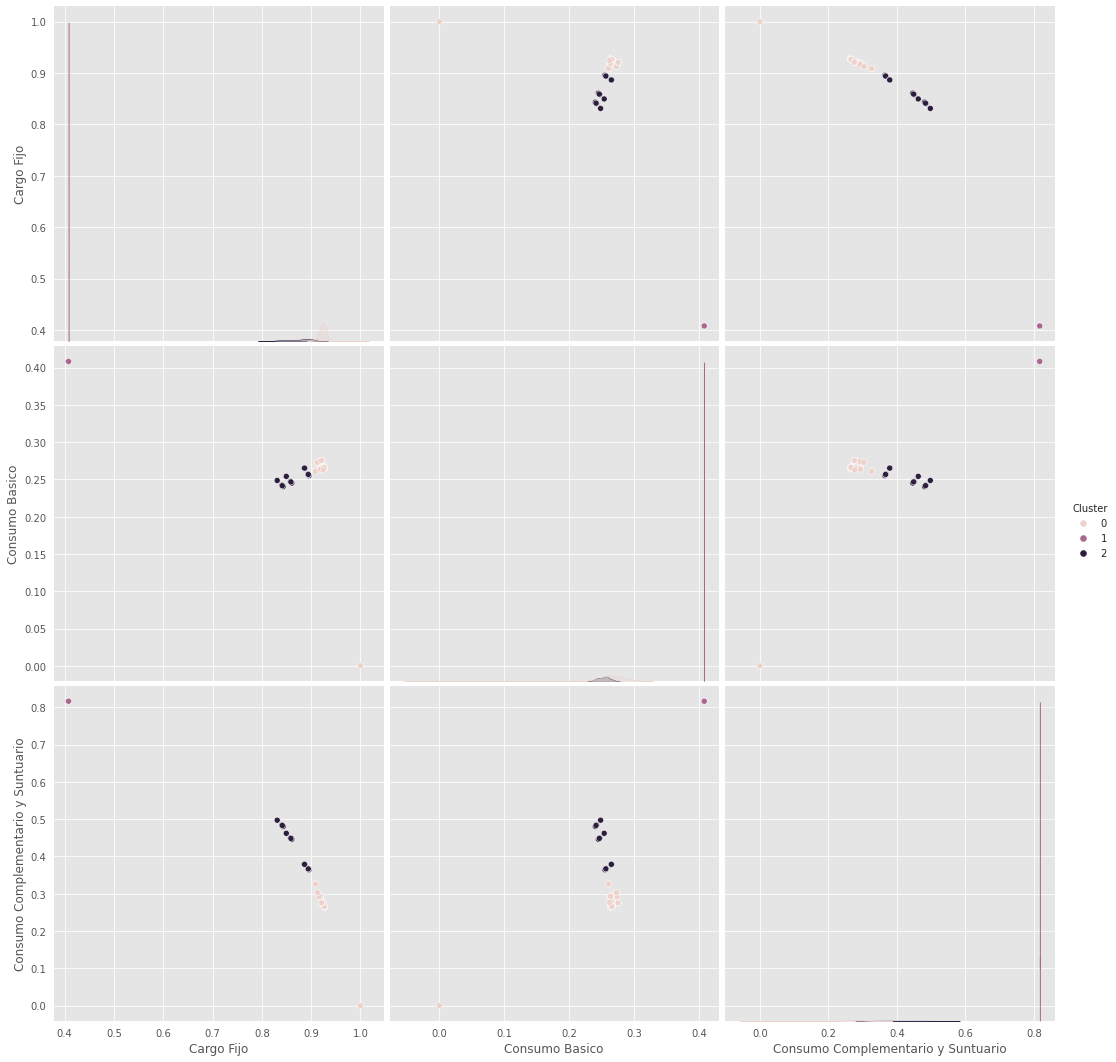

In [ ]:
datos_scaled['Cluster']=cluster.labels_
sb.pairplot(datos_scaled.dropna(), hue='Cluster',size=5,vars=['Cargo Fijo','Consumo Basico','Consumo Complementario y Suntuario'],kind='scatter')

# Clustering K-means

Estrato
1    12
2    12
3    12
4    12
5    12
6    12
dtype: int64


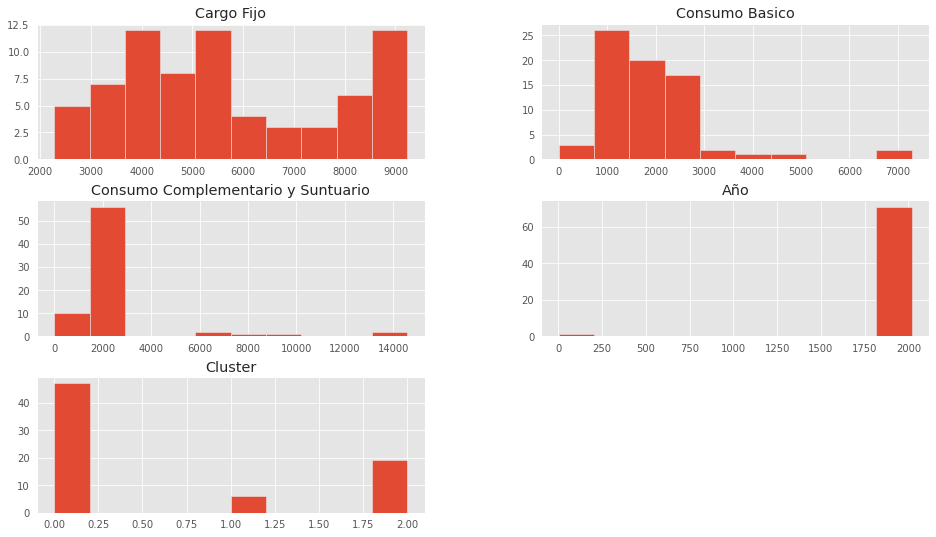

In [ ]:
#Obtenemos información de la categoria estado civil
print(datos.groupby('Estrato').size())
#Visualización de registros
datos.drop(['Estrato2'],1).hist()
plt.show()

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

NameError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


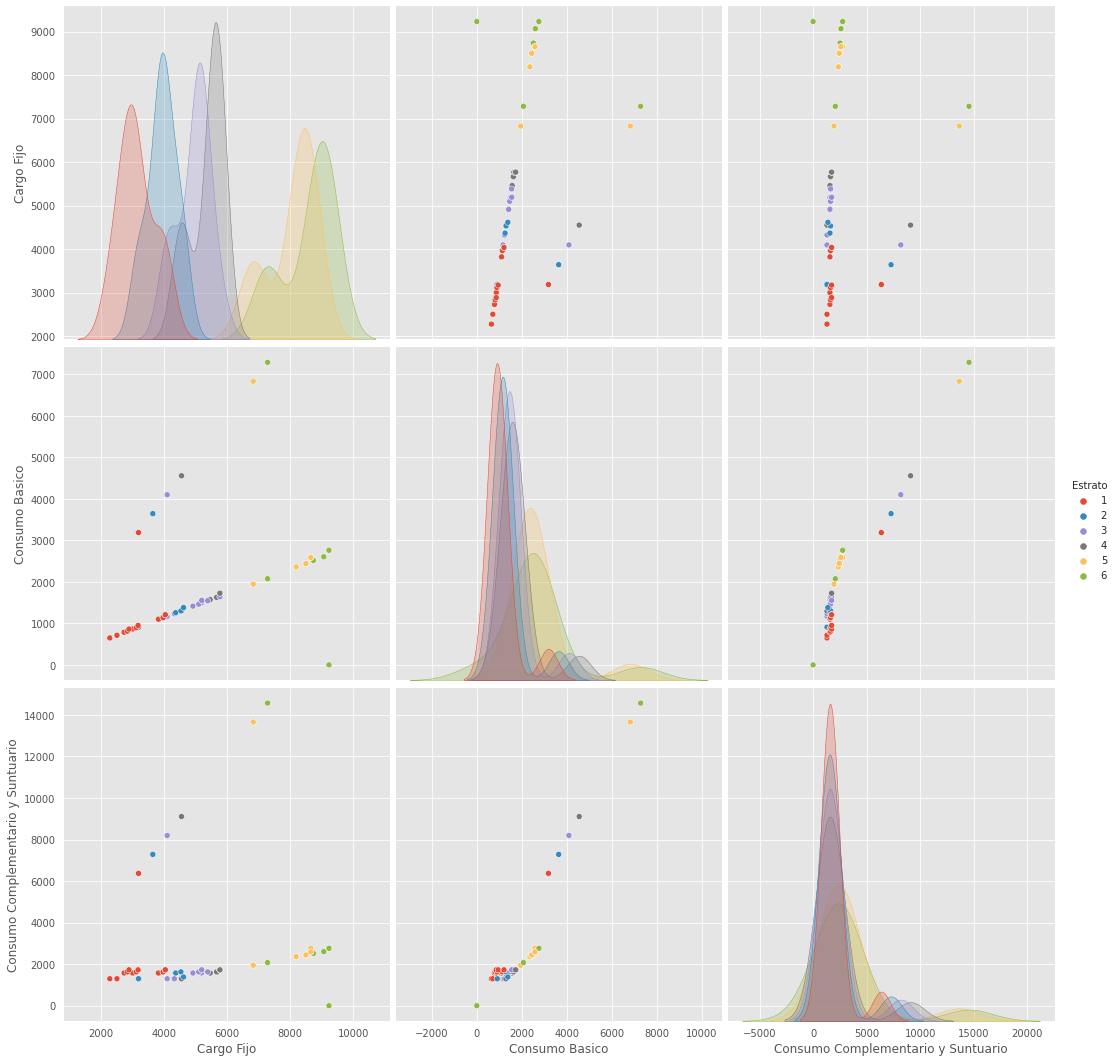

In [ ]:
#cRUZAMOS LAS 3 DIMENSIONES Y LAS CRUZAMOS PARA ENCONTRAR PATRONES DE AGRUPACIÓN Y RELACIÓN CON SUS CATEGORIAS
sb.pairplot(datos.dropna(), hue='Estrato',size=5,vars=['Cargo Fijo','Consumo Basico','Consumo Complementario y Suntuario'],kind='scatter')

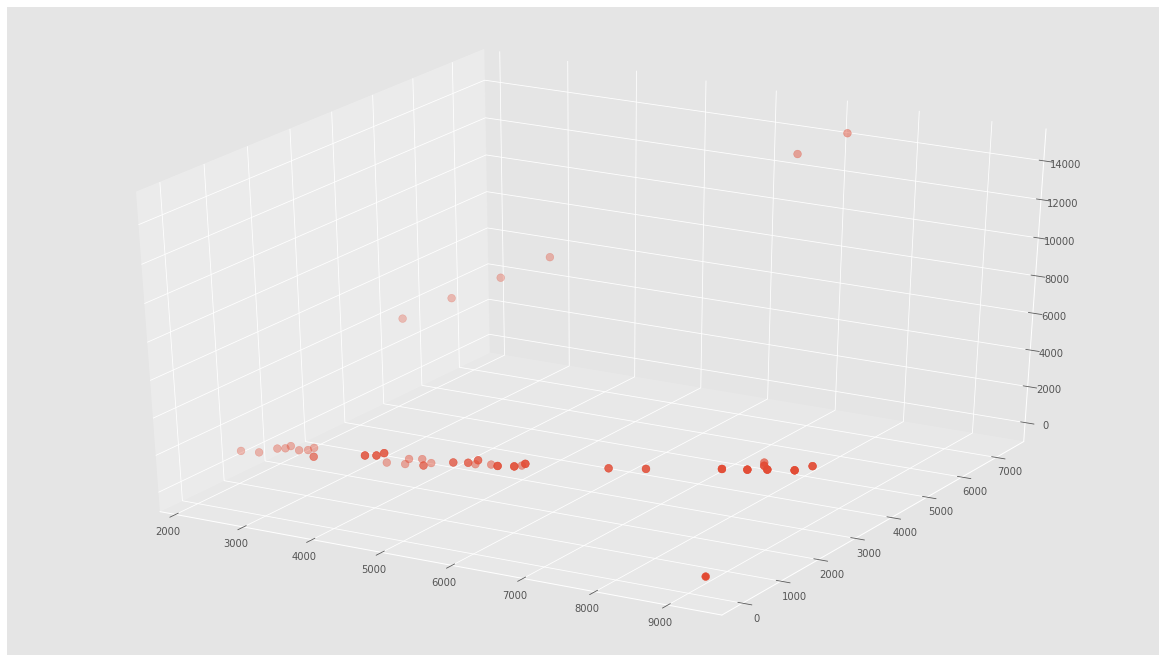

In [ ]:
X = np.array(datos[['Cargo Fijo','Consumo Basico','Consumo Complementario y Suntuario']])
Y = np.array(datos['Estrato2'])

fig = plt.figure()
ax = Axes3D(fig)
colors=['blue','red','green','yellow']
asignar=[]
ax.scatter(X[:, 0], X[:, 1], X[:, 2],s=60)


In [ ]:
#Normalizamos los valores para que sólo quede como máximo el valor 1 y minimo el valor 0
datos_norm = (datos_dropped-datos_dropped.min())/(datos_dropped.max()-datos_dropped.min())
datos_norm

,Cargo Fijo,Consumo Basico,Consumo Complementario y Suntuario
0,0.000000,0.089050,0.089019
1,0.130868,0.124588,0.089019
2,0.261736,0.160126,0.089019
3,0.327170,0.177964,0.089019
4,0.654484,0.267014,0.133562
...,...,...,...
67,0.336342,0.189443,0.094760
68,0.419300,0.213123,0.118450
69,0.502257,0.236803,0.118450
70,0.917043,0.355204,0.177675


In [ ]:
datos_norm.describe()

,Cargo Fijo,Consumo Basico,Consumo Complementario y Suntuario
count,72.000000,72.000000,72.000000
mean,0.487087,0.260415,0.171199
std,0.302980,0.164459,0.169025
min,0.000000,0.000000,0.000000
25%,0.250804,0.164353,0.107962
50%,0.419300,0.215834,0.118450
75%,0.752509,0.334874,0.167506
max,1.000000,1.000000,1.000000


Definimos la cantidad óptima de cluster, para ello hacemos uso del método del codo

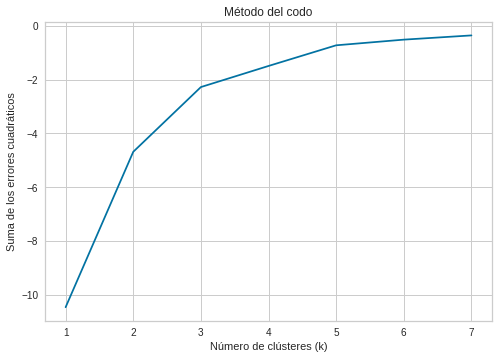

In [ ]:
nc = range(1, 8) # El número de iteraciones que queremos hacer.
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(datos_norm).score(datos_norm) for i in range(len(kmeans))]
score
plt.title('Método del codo')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc,score)

#Se ejecuta modelo K-Means para 3 clusters

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(datos_dropped)
# Get the cluster centroids
print(kmeans.cluster_centers_)
    
# Get the cluster labels
print(kmeans.labels_)

[[4382.40181818 1271.63090909 1571.39204545]
 [4930.5        4934.         9864.66666667]
 [8423.93863636 2322.42136364 2330.26590909]]
[0 0 0 0 2 2 0 0 0 0 2 2 1 1 1 1 1 1 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 2 2 0
 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 2 2]


In [ ]:
x = datos_dropped.values
kmeans3 = KMeans(n_clusters=3)
y_kmeans3 = kmeans3.fit_predict(x)
print(y_kmeans3)

kmeans3.cluster_centers_

[0 0 0 0 2 2 0 0 0 0 2 2 1 1 1 1 1 1 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 2 2 0
 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 2 2]


array([[4382.40181818, 1271.63090909, 1571.39204545],
       [4930.5       , 4934.        , 9864.66666667],
       [8423.93863636, 2322.42136364, 2330.26590909]])

In [ ]:
#Guardamos los clusters en el dataframe
datos['Kmeans_Cluster'] = kmeans.labels_
datos.head()

,Municipio,Estrato,Cargo Fijo,Consumo Basico,Consumo Complementario y Suntuario,Año,Estrato2,Cluster,Kmeans_Cluster
0,Bucaramanga,1,2276.0,649.0,1297.0,2016.0,0,2,0
1,Bucaramanga,2,3186.0,908.0,1297.0,2016.0,1,2,0
2,Bucaramanga,3,4096.0,1167.0,1297.0,2016.0,2,0,0
3,Bucaramanga,4,4551.0,1297.0,1297.0,2016.0,3,0,0
4,Bucaramanga,5,6827.0,1946.0,1946.0,2016.0,4,0,2


Visualización de los clusters

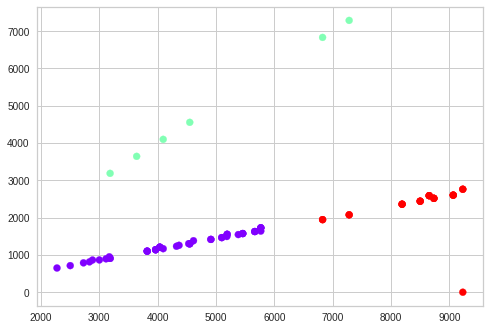

In [ ]:
plt.scatter(x[:, 0], x[:, 1], c=y_kmeans3, cmap='rainbow')

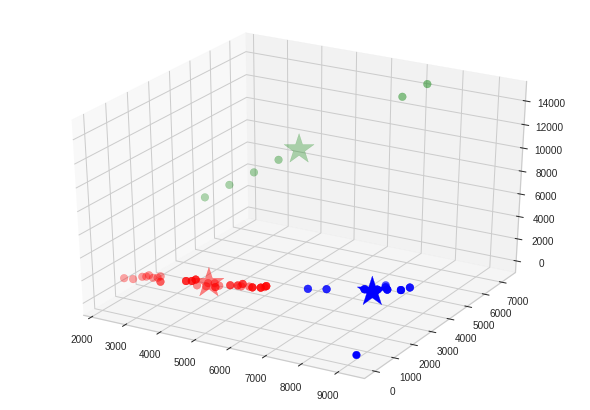

In [ ]:
#Visualización 3D de los cluster
labels = y_kmeans3
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

# Clustering Probabilístico (Gaussian Mixture Models)



Entrenamiento modelo

In [ ]:
# Entrenamos el modelo de mezcla gaussiana
gm3 = GaussianMixture(n_components=3, covariance_type="full")
gm3.fit(datos_dropped)
pred = gm3.predict(datos_dropped)

Visualización clusters

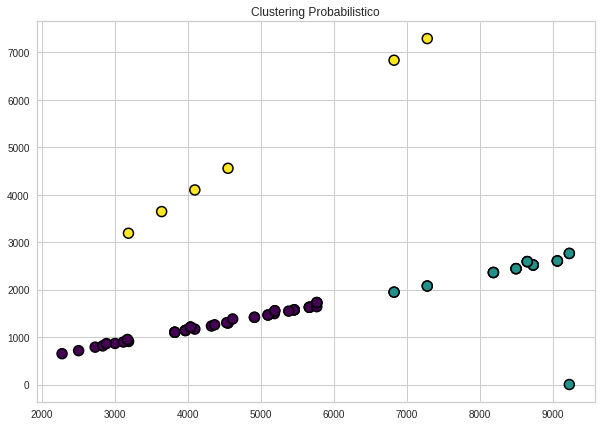

In [ ]:
plt.figure( figsize=(10,7))
plt.scatter(X[:,0], X[:,1], c=pred, edgecolor='black', lw=1.5, s=100, cmap=plt.get_cmap('viridis'))
plt.title('Clustering Probabilistico')
plt.show()

Validación número clusters

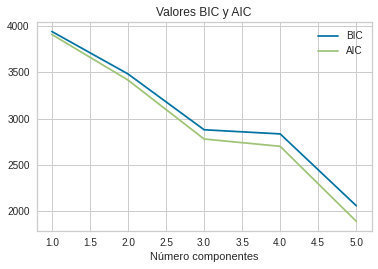

In [ ]:
n_components = range(1, 6)
valores_bic = []
valores_aic = []

for i in n_components:
    modelo = GaussianMixture(n_components=i, covariance_type="full")
    modelo = modelo.fit(datos_dropped)
    valores_bic.append(modelo.bic(datos_dropped))
    valores_aic.append(modelo.aic(datos_dropped))

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(n_components, valores_bic, label='BIC')
ax.plot(n_components, valores_aic, label='AIC')
ax.set_title("Valores BIC y AIC")
ax.set_xlabel("Número componentes")
ax.legend();

In [ ]:
print(f"Número óptimo acorde al BIC: {range(1, 6)[np.argmin(valores_bic)]}")
print(f"Número óptimo acorde al AIC: {range(1, 6)[np.argmin(valores_aic)]}")

Número óptimo acorde al BIC: 5
Número óptimo acorde al AIC: 5
